# Experimental Growth Parameter Calculations

### Load imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

### Define a function for calculating growth parameters

In [2]:
def get_trial_growth_parameters(
    growth_df=None, 
    trial_num=None, 
    molar_mass=None,
    substrate=None
):
    # define the conversion factor from OD to g/L
    yarrowia_g_per_OD = 0.46

    substrate_column = f'{substrate}_g/l_{trial_num}'
    biomass_column = f'yarrowia_OD_{trial_num}'

    time_h = growth_df['time_h'].tolist()
    substrate_g_L = growth_df[substrate_column].tolist()
    substrate_mmols_L = [1000 * g / molar_mass for g in substrate_g_L]
    starting_substrate = substrate_mmols_L[0]
    final_substrate = substrate_mmols_L[-1]

    yarrowia_OD = growth_df[biomass_column].tolist()
    yarrowia_g_L = [y * yarrowia_g_per_OD for y in yarrowia_OD]
    starting_biomass = yarrowia_g_L[0]
    final_biomass = yarrowia_g_L[-1]

    growth_rate, _, _, _, _ = stats.linregress(time_h, [math.log(val) for val in yarrowia_g_L])
    fitted_biomass_conc = [starting_biomass * math.exp(growth_rate * time) for time in time_h]
    fitted_biomass_produced = [biomass_conc - starting_biomass for biomass_conc in fitted_biomass_conc]

    delta_X = final_biomass - starting_biomass
    delta_S = starting_substrate - final_substrate
    yield_coefficient = delta_X / delta_S
    substrate_uptake_rate = (1/yield_coefficient) * growth_rate

    fitted_substrate_conc = [starting_substrate - (1 / yield_coefficient) * biomass_produced 
                                for biomass_produced in fitted_biomass_produced]
    
    # define a plotting area with two subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

    # Set the background color of the figure to white
    fig.patch.set_facecolor('white')

    for ax in axes:
        # Set the background color of the plots to white
        ax.set_facecolor('white')
        
        # Set the color of the spines (borders) to black
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
        
        # Set the color of the titles, labels, ticks, and tick labels to black
        ax.title.set_color('black')
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.tick_params(axis='both', colors='black')

    # plot biomass data on the left
    axes[0].set_title('Biomass Growth', fontsize=16)
    axes[0].set_xlabel('Time (hr)', fontsize=14)
    axes[0].set_ylabel('Biomass (g/L)', fontsize=14)

    # plot experimental biomass concentration data points
    axes[0].plot(time_h, yarrowia_g_L, 'o', color='red')
    # plot fitted biomass concentration curve
    axes[0].plot(time_h, fitted_biomass_conc, '-', color='red')

    # plot substrate consumption data on the right
    axes[1].set_title(f'{substrate.capitalize()} Consumption', fontsize=16)
    axes[1].set_ylabel(f'{substrate.capitalize()} (mmol/L)', fontsize=14)
    axes[1].set_xlabel('Time (hr)', fontsize=14)

    # plot experimental substrate concentration data points
    axes[1].plot(time_h, substrate_mmols_L, 'o', color='blue')
    # plot fitted substrate concentration curve
    axes[1].plot(time_h, fitted_substrate_conc, '-', color='blue')

    return growth_rate, yield_coefficient, substrate_uptake_rate

In [3]:
def get_average_growth_parameters(growth_df=None, substrate=None, molar_mass=None):
    growth_rates = []
    yield_coefficients = [] 
    substrate_uptake_rates = []

    # loop over trials
    for trial_num in ['1', '2', '3']:
        
        # get the growth parameters for each trial
        growth_rate, yield_coefficient, substrate_uptake_rate = get_trial_growth_parameters(
            growth_df=growth_df, 
            trial_num=trial_num, 
            molar_mass=molar_mass, 
            substrate=substrate
        )

        print(f'Trial {trial_num}:')
        print(f'growth_rate = {growth_rate:.3f} hr-1')
        print(f'yield coefficient = {yield_coefficient:.3f} g biomass/mmol {substrate}')
        print(f'substrate consumption rate = {substrate_uptake_rate:.3f} mmol {substrate}/gram biomass * hr')
        print()

        # append the growth parameters to the lists
        growth_rates.append(growth_rate)
        yield_coefficients.append(yield_coefficient)
        substrate_uptake_rates.append(substrate_uptake_rate)

    # calculate the average parameter values
    growth_rate = np.average(growth_rates)
    yield_coefficient = np.average(yield_coefficients)
    substrate_uptake_rate = np.average(substrate_uptake_rates)

    # calculate the standard deviation of parameter values
    growth_rate_std = np.std(growth_rates)
    yield_coefficient_std = np.std(yield_coefficients)
    substrate_uptake_rate_std = np.std(substrate_uptake_rates)

    # print the growth parameters
    print('Average Growth Parameters:')
    print(f'growth_rate = {growth_rate:.3f} ± {growth_rate_std:.3f} hr-1')
    print(f'yield coefficient = {yield_coefficient:.3f} ± {yield_coefficient_std:.3f} g biomass/mmol {substrate}')
    print(f'substrate consumption rate = {substrate_uptake_rate:.3f} ± {substrate_uptake_rate_std:.3f} mmol {substrate}/gram biomass * hr') 

### Load glucose growth curve data

In [4]:
# load data/growth_curves/glucose_growth_data.csv
glucose_growth_df = pd.read_csv('../data/growth_curves/glucose_growth_data.csv')

glucose_growth_df

,time_h,glucose_g/l_1,glucose_g/l_2,glucose_g/l_3,yarrowia_OD_1,yarrowia_OD_2,yarrowia_OD_3
0,0,1.680009,1.712100,1.908116,0.0788,0.0788,0.0788
1,5,1.752865,1.983573,1.939340,0.1621,0.1652,0.1589
2,8,1.220327,1.311396,1.222061,0.4818,0.4578,0.5407
3,11,1.091963,1.187368,0.882937,1.2770,1.3020,1.2850
4,15,0.058111,0.051172,0.047703,3.3720,3.6810,3.8010


### Get glucose growth parameters

Trial 1:
growth_rate = 0.262 hr-1
yield coefficient = 0.168 g biomass/mmol glucose
substrate consumption rate = 1.558 mmol glucose/gram biomass * hr

Trial 2:
growth_rate = 0.267 hr-1
yield coefficient = 0.180 g biomass/mmol glucose
substrate consumption rate = 1.486 mmol glucose/gram biomass * hr

Trial 3:
growth_rate = 0.270 hr-1
yield coefficient = 0.166 g biomass/mmol glucose
substrate consumption rate = 1.626 mmol glucose/gram biomass * hr

Average Growth Parameters:
growth_rate = 0.266 ± 0.003 hr-1
yield coefficient = 0.171 ± 0.006 g biomass/mmol glucose
substrate consumption rate = 1.557 ± 0.057 mmol glucose/gram biomass * hr


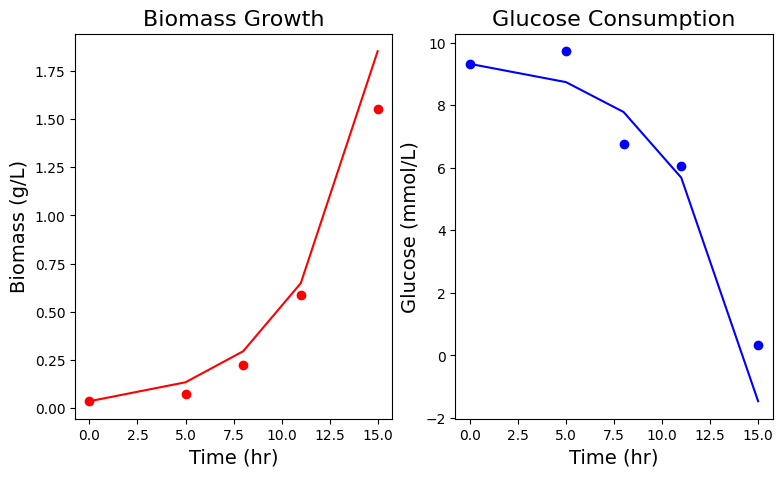

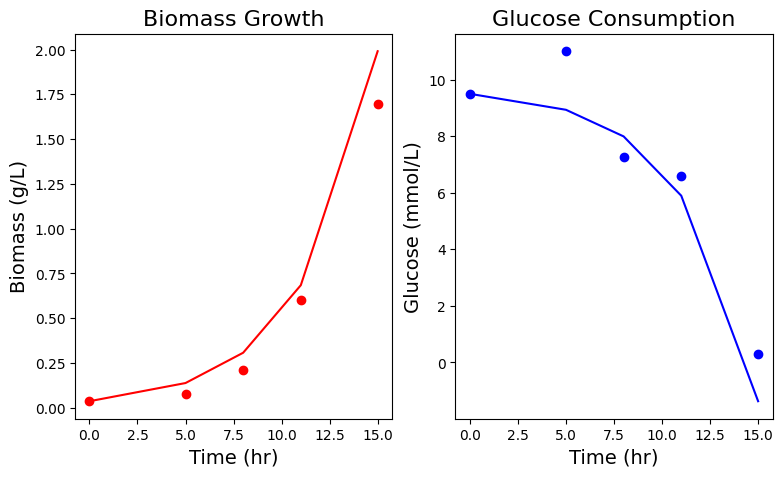

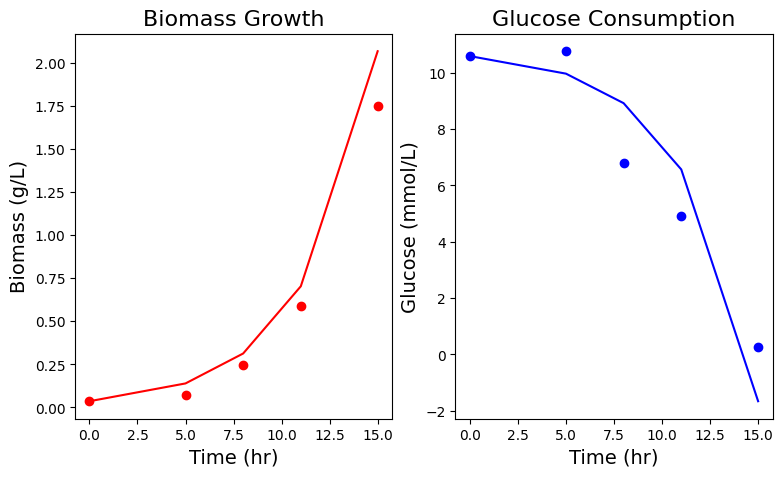

In [5]:
get_average_growth_parameters(growth_df=glucose_growth_df, substrate='glucose', molar_mass=180.16)

### Load glycerol data

In [6]:
# load data/growth_curves/glycerol_growth_data.csv
glycerol_growth_df = pd.read_csv('../data/growth_curves/glycerol_growth_data.csv')

glycerol_growth_df

,time_h,glycerol_g/l_1,glycerol_g/l_2,glycerol_g/l_3,yarrowia_OD_1,yarrowia_OD_2,yarrowia_OD_3
0,0,1.389,1.812,1.998,0.0785,0.0785,0.0785
1,5,2.678,1.736,2.263,0.2847,0.3147,0.2809
2,8,1.792,1.626,1.553,1.3272,1.4934,1.3482
3,11,0.038,0.022,0.008,3.6400,3.6300,3.6945


### Calculate glycerol parameters

Trial 1:
growth_rate = 0.357 hr-1
yield coefficient = 0.112 g biomass/mmol glycerol
substrate consumption rate = 3.195 mmol glycerol/gram biomass * hr

Trial 2:
growth_rate = 0.359 hr-1
yield coefficient = 0.084 g biomass/mmol glycerol
substrate consumption rate = 4.267 mmol glycerol/gram biomass * hr

Trial 3:
growth_rate = 0.359 hr-1
yield coefficient = 0.077 g biomass/mmol glycerol
substrate consumption rate = 4.659 mmol glycerol/gram biomass * hr

Average Growth Parameters:
growth_rate = 0.358 ± 0.001 hr-1
yield coefficient = 0.091 ± 0.015 g biomass/mmol glycerol
substrate consumption rate = 4.041 ± 0.619 mmol glycerol/gram biomass * hr


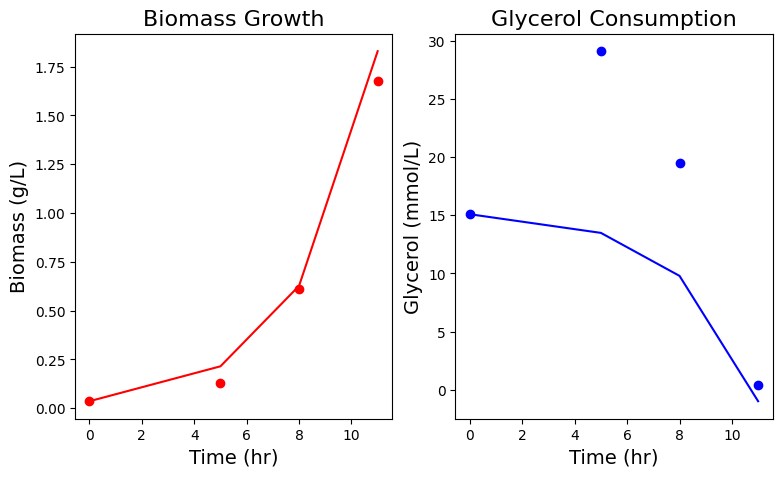

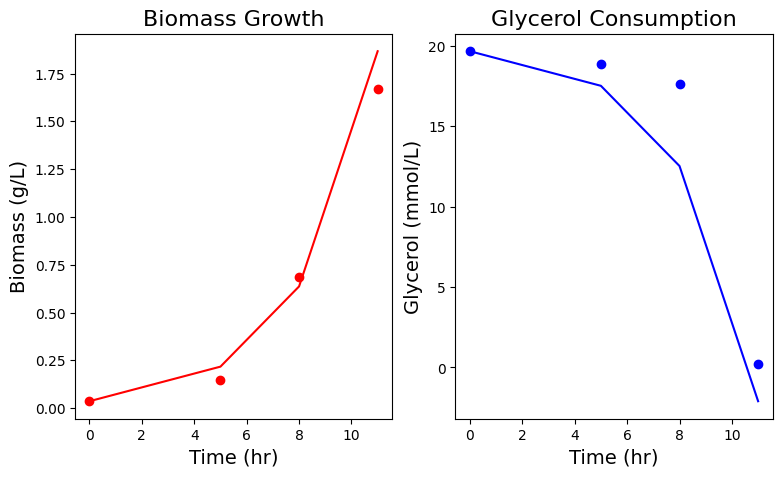

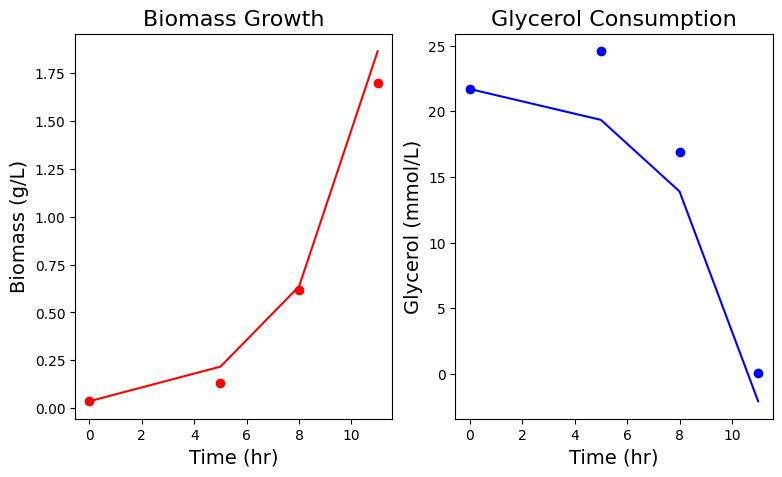

In [7]:
get_average_growth_parameters(growth_df=glycerol_growth_df, substrate='glycerol', molar_mass=92.09)

### Load oleic acid growth curve data

In [10]:
oleic_acid_growth_df = pd.read_csv('../data/growth_curves/oleic_acid_growth_data.csv')

oleic_acid_growth_df

,time_h,oleic_acid_g/l_1,oleic_acid_g/l_2,oleic_acid_g/l_3,yarrowia_OD_1,yarrowia_OD_2,yarrowia_OD_3
0,0,NaN,NaN,NaN,0.0589,0.0589,0.0589
1,5,NaN,NaN,NaN,0.1391,0.1565,0.1492
2,8,NaN,NaN,NaN,0.3066,0.2490,0.2412
3,11,NaN,NaN,NaN,0.6885,0.5835,0.6690
4,15,NaN,NaN,NaN,2.8890,4.1260,3.2030


### Get glucose growth parameters

Trial 1:
growth_rate = 0.259 hr-1
yield coefficient = nan g biomass/mmol oleic_acid
substrate consumption rate = nan mmol oleic_acid/gram biomass * hr

Trial 2:
growth_rate = 0.271 hr-1
yield coefficient = nan g biomass/mmol oleic_acid
substrate consumption rate = nan mmol oleic_acid/gram biomass * hr

Trial 3:
growth_rate = 0.262 hr-1
yield coefficient = nan g biomass/mmol oleic_acid
substrate consumption rate = nan mmol oleic_acid/gram biomass * hr

Average Growth Parameters:
growth_rate = 0.264 ± 0.005 hr-1
yield coefficient = nan ± nan g biomass/mmol oleic_acid
substrate consumption rate = nan ± nan mmol oleic_acid/gram biomass * hr


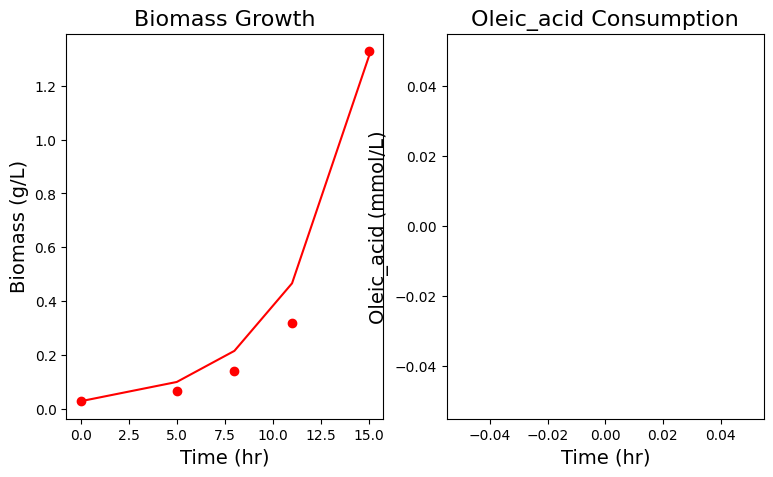

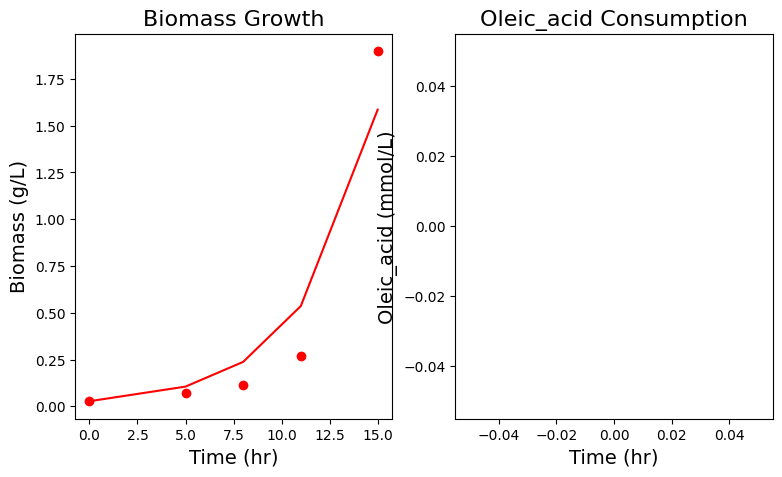

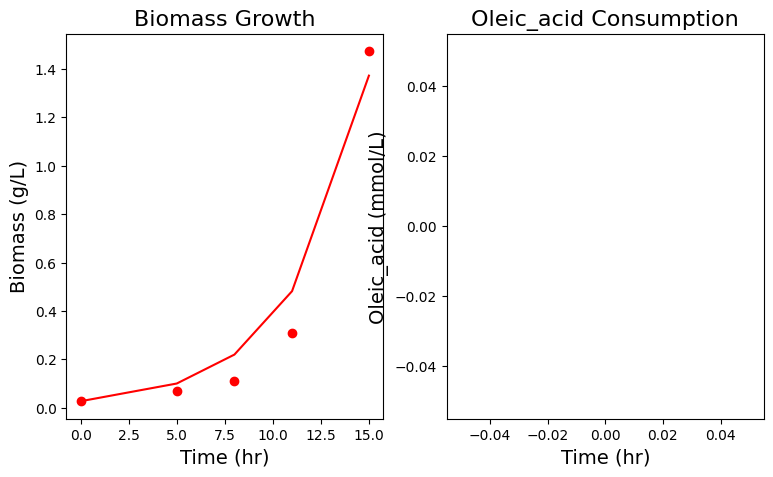

In [12]:
get_average_growth_parameters(growth_df=oleic_acid_growth_df, substrate='oleic_acid', molar_mass=282.46)